In [1]:
import numpy as np
import torch

from pina.problem import SpatialProblem
from pina.operators import nabla, grad, div
from pina import Condition, Span, LabelTensor

import argparse
import sys
import numpy as np
import torch
from torch.nn import ReLU, Tanh, Softplus

from pina import PINN, LabelTensor, Plotter
from pina.model import FeedForward
from pina.adaptive_functions import AdaptiveSin, AdaptiveCos, AdaptiveTanh
# from problems.stokes import Stokes

import matplotlib.pyplot as plt

In [2]:
class Stokes(SpatialProblem):

    # assign output/ spatial variables
    output_variables = ['ux', 'uy', 'p']
    spatial_domain = Span({'x': [-2, 2], 'y': [-1, 1]})

    # define the momentum equation
    def momentum(input_, output_):
        nabla_ = torch.hstack((LabelTensor(nabla(output_.extract(['ux']), input_), ['x']),
            LabelTensor(nabla(output_.extract(['uy']), input_), ['y'])))
        return - nabla_ + grad(output_.extract(['p']), input_)

    # define the continuity equation
    def continuity(input_, output_):
        return div(output_.extract(['ux', 'uy']), input_)

    # define the inlet velocity
    def inlet(input_, output_):
        value = 2 * (1 - input_.extract(['y'])**2)
        return output_.extract(['ux']) - value

    # define the outlet pressure
    def outlet(input_, output_):
        value = 0.0
        return output_.extract(['p']) - value

    # define the wall condition
    def wall(input_, output_):
        value = 0.0
        return output_.extract(['ux', 'uy']) - value

    # define vorticity condition
    def vorticity(input_, output_):
        u_y = grad(output_, input_, components=['ux'], d=['y'])
        v_x = grad(output_, input_, components=['uy'], d=['x'])
        return torch.abs(u_y - v_x)

    # problem condition statement
    conditions = {
        'gamma_top': Condition(location=Span({'x': [-2, 2], 'y':  1}), function=wall),
        'gamma_bot': Condition(location=Span({'x': [-2, 2], 'y': -1}), function=wall),
        'gamma_out': Condition(location=Span({'x':  2, 'y': [-1, 1]}), function=outlet),
        'gamma_in':  Condition(location=Span({'x': -2, 'y': [-1, 1]}), function=inlet),
        'D1': Condition(location=Span({'x': [-2, 2], 'y': [-1, 1]}), function=momentum),
        'D2': Condition(location=Span({'x': [-2, 2], 'y': [-1, 1]}), function=continuity),
        'vorticity': Condition(location=Span({'x': [-2, 2], 'y': [-1, 1]}), function=vorticity, data_weight=0.),
    }

stokes_problem = Stokes()
model = FeedForward(
    layers=[10, 10, 10, 10],
    output_variables=stokes_problem.output_variables,
    input_variables=stokes_problem.input_variables,
    func=Softplus,
)

In [4]:
pinn_vanilla = PINN(
    stokes_problem,
    model,
    lr=0.006,
    error_norm='mse',
    regularizer=1e-8)

# if args.s:

pinn_vanilla.span_pts(200, 'grid', locations=['gamma_top', 'gamma_bot', 'gamma_in', 'gamma_out'])
pinn_vanilla.span_pts(2000, 'latin', seed=42, locations=['D1'])
pinn_vanilla.span_pts(2000, 'latin', seed=42, locations=['D2'])
# Initial sampling is required for 'vorticity'
pinn_vanilla.span_pts(1, 'random', locations=['vorticity'])

pinn_vanilla.train(5000, 100)
print(f"test loss: {pinn_vanilla.cal_loss()}")

              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00000] 3.918675e-02 2.938359e-03 1.307360e-02 2.292794e-03 3.306157e-03 6.683125e-03 1.089272e-02 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00001] 3.491372e-01 1.184605e-02 5.176915e-02 2.710929e-01 2.318210e-03 8.821336e-03 3.289581e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00100] 1.864966e-02 3.284914e-03 4.314194e-03 5.839805e-05 2.221577e-03 3.658164e-03 5.112411e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00200] 1.980096e-02 3.446379e-03 4.352245e-03 3.140346e-04 2.785737e-03 4.338355e-03 4.564208e-03 0.000000e+00 
              sum          gamma_topwal gamma_bo

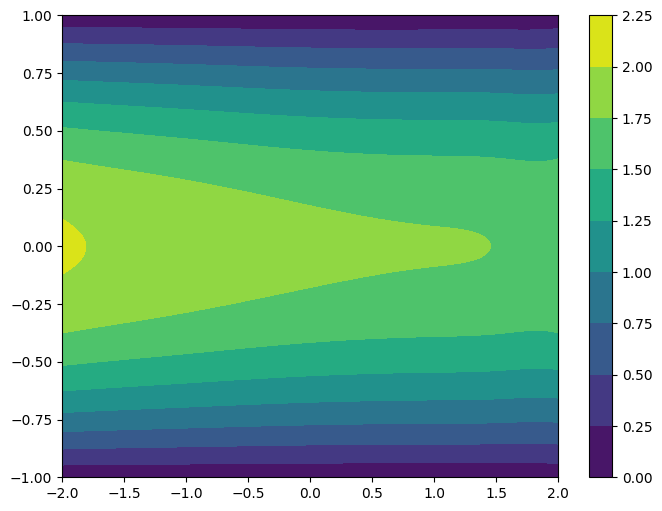

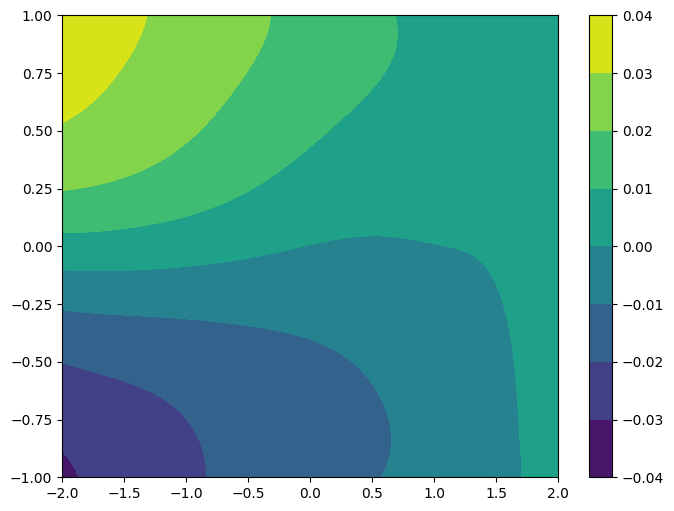

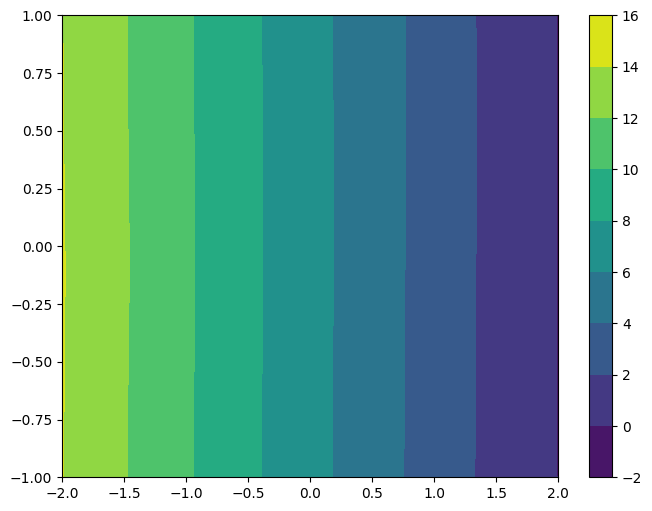

In [12]:
plotter = Plotter()
plotter.plot(pinn_vanilla, components='ux')
plotter.plot(pinn_vanilla, components='uy')
plotter.plot(pinn_vanilla, components='p')

              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00000] 1.689370e-02 1.333615e-03 3.820851e-03 2.107329e-03 4.598716e-03 3.767678e-03 1.265509e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00001] 1.782154e-01 3.303058e-03 1.734772e-02 1.111857e-01 1.938192e-02 2.598937e-02 1.007687e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00100] 6.986999e-03 6.181107e-04 8.223561e-04 2.295406e-04 9.164792e-04 2.946269e-03 1.454243e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 00200] 1.575700e-02 3.800137e-04 2.952944e-04 7.349313e-04 1.522164e-04 1.223354e-02 1.961005e-03 0.000000e+00 
              sum          gamma_topwal gamma_bo

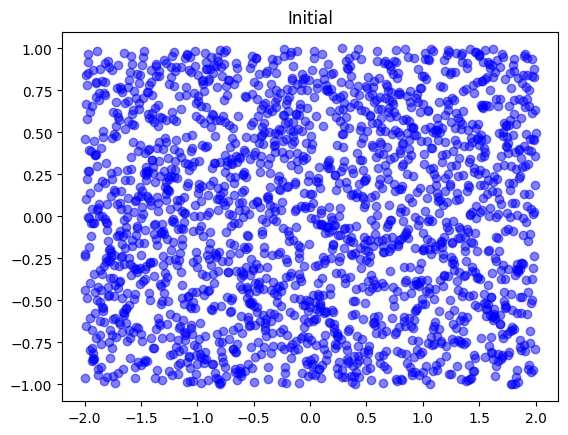

sorted: no labels
LabelTensor([[3.9872e+00],
             [3.9576e+00],
             [3.9568e+00],
             ...,
             [1.0941e-03],
             [9.6948e-04],
             [1.8029e-04]], grad_fn=<AliasBackward0>)
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 02000] 2.267239e-03 2.373178e-04 2.507142e-04 4.360235e-06 9.351883e-05 6.167173e-04 1.064611e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 02001] 3.009944e-03 2.631739e-04 2.763901e-04 9.644001e-06 8.338500e-06 1.408280e-03 1.044118e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 02100] 2.257823e-01 5.977078e-03 9.404549e-03 6.214496e-02 1.089657e-02 1.356206e-01 1.738550e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_ou

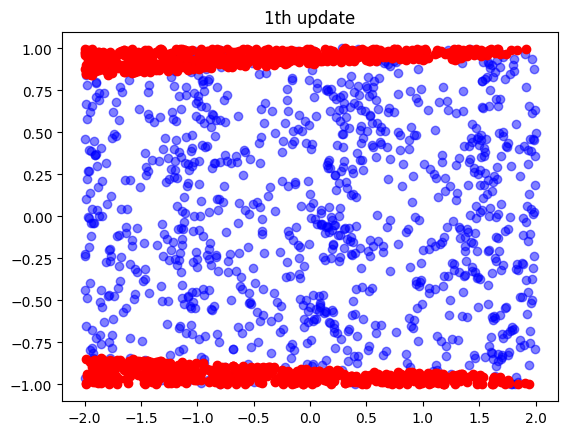

sorted: no labels
LabelTensor([[3.8791e+00],
             [3.8777e+00],
             [3.8687e+00],
             ...,
             [1.0344e-03],
             [6.0029e-04],
             [5.3819e-04]], grad_fn=<AliasBackward0>)
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 03000] 4.924262e-02 9.394402e-04 1.717271e-03 1.364992e-02 1.579373e-02 1.595490e-02 1.187369e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 03001] 3.411761e-02 1.836886e-03 2.503395e-03 7.295621e-03 6.764350e-03 1.346799e-02 2.249366e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 03100] 5.471888e-03 4.828337e-04 6.571921e-04 6.189464e-05 4.157762e-04 2.041819e-03 1.812372e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_ou

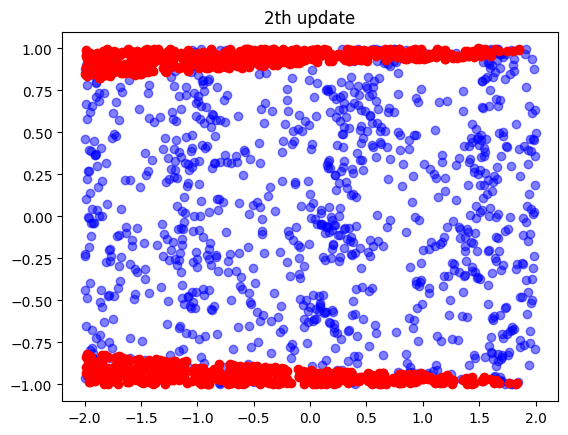

sorted: no labels
LabelTensor([[3.9469e+00],
             [3.9185e+00],
             [3.8975e+00],
             ...,
             [1.3799e-03],
             [4.4414e-04],
             [2.2641e-04]], grad_fn=<AliasBackward0>)
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 04000] 1.838474e-02 6.728994e-04 1.326229e-03 2.045848e-03 8.646124e-03 4.628611e-03 1.065025e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 04001] 1.698707e-02 1.455553e-03 2.126975e-03 1.967482e-03 4.522291e-03 5.283378e-03 1.631390e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_outout gamma_ininle D1momentum   D2continuity vorticityvor 
[epoch 04100] 4.545543e-03 4.549813e-04 6.121890e-04 1.979885e-04 4.384619e-04 1.376676e-03 1.465246e-03 0.000000e+00 
              sum          gamma_topwal gamma_botwal gamma_ou

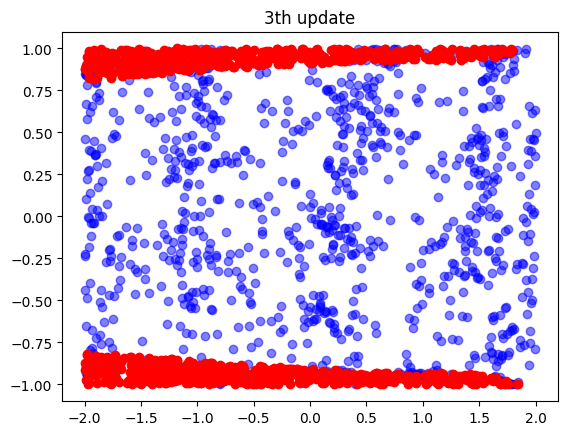

test loss: [LabelTensor([-0.0236,  0.0027], grad_fn=<AliasBackward0>), LabelTensor([-0.0304], grad_fn=<AliasBackward0>)]


In [10]:
pinn_adapt = PINN(
    stokes_problem,
    model,
    lr=0.006,
    error_norm='mse',
    regularizer=1e-8)

# if args.s:

pinn_adapt.span_pts(200, 'grid', locations=['gamma_top', 'gamma_bot', 'gamma_in', 'gamma_out'])
pinn_adapt.span_pts(2000, 'latin', seed=42, locations=['D1'])
pinn_adapt.span_pts(2000, 'latin', seed=42, locations=['D2'])
# Initial sampling is required for 'vorticity'
pinn_adapt.span_pts(1, 'random', locations=['vorticity'])

pinn_adapt.train(2000, 100)
plt.scatter(pinn_adapt.input_pts['D1'][:,0].detach().numpy(), pinn_adapt.input_pts['D1'][:,1].detach().numpy(),alpha=0.5, color='b')
plt.title('Initial')
plt.show()

N_adapt = 1000
for i in range(3):
    pinn_adapt.update_pts(N_adapt, weight_mass=0.5, locations=['D1', 'D2', 'vorticity'])
    plt.scatter(pinn_adapt.input_pts['D1'][:,0][:-N_adapt].detach().numpy(), pinn_adapt.input_pts['D1'][:,1][:-N_adapt].detach().numpy(), alpha=0.5, color='b')
    plt.scatter(pinn_adapt.input_pts['D1'][:,0][-N_adapt:].detach().numpy(), pinn_adapt.input_pts['D1'][:,1][-N_adapt:].detach().numpy(), alpha=1., color='r')

    pinn_adapt.train(1000, 100)
    plt.title(f'{i+1}th update')
    plt.show()
print(f"test loss: {pinn_adapt.cal_loss()}")

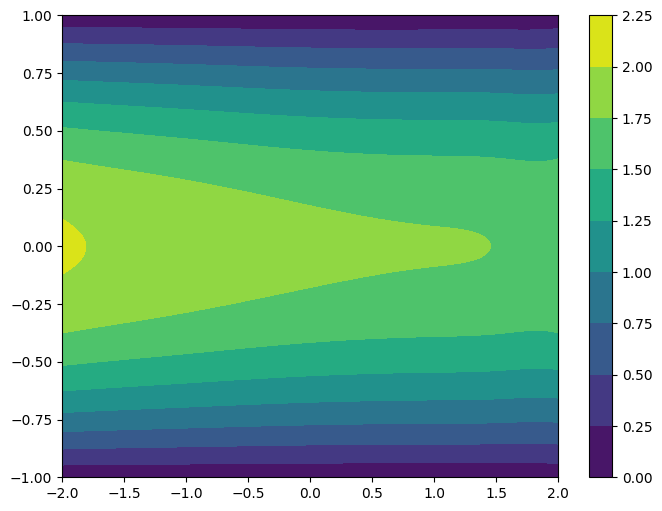

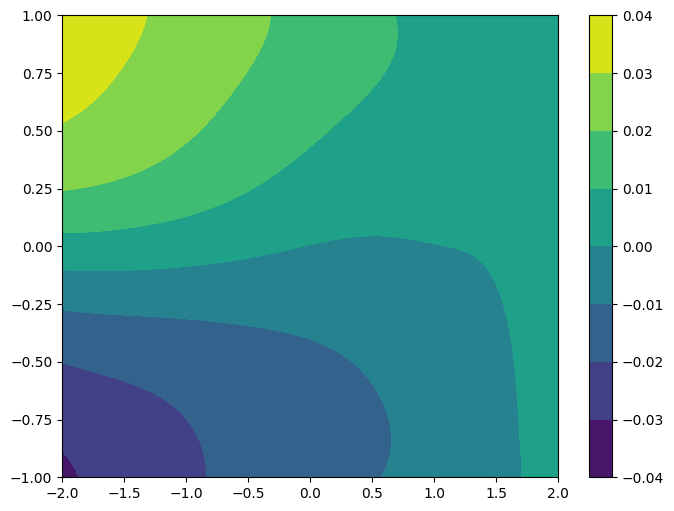

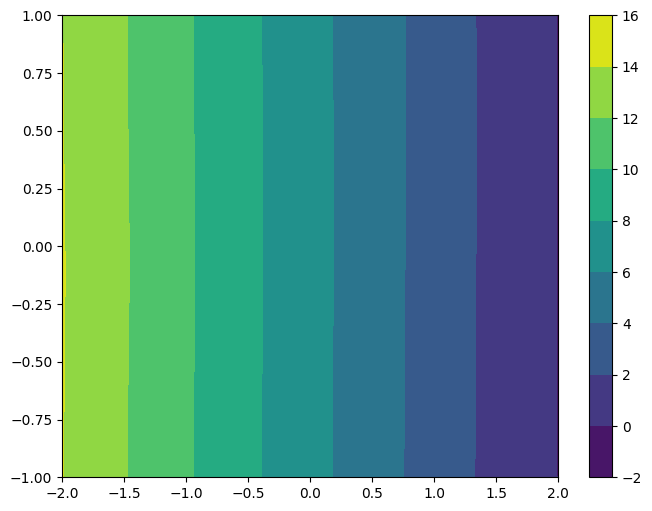

In [11]:
plotter = Plotter()
plotter.plot(pinn_adapt, components='ux')
plotter.plot(pinn_adapt, components='uy')
plotter.plot(pinn_adapt, components='p')

(2000,)


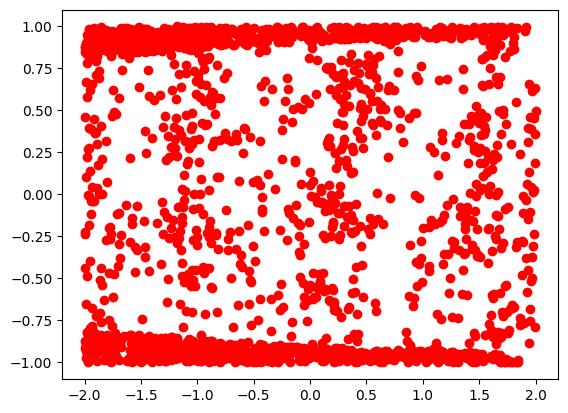

In [13]:
print(pinn_adapt.input_pts['D1'][:,0].detach().numpy().shape)
plt.scatter(pinn_adapt.input_pts['D1'][:,0].detach().numpy(), pinn_adapt.input_pts['D1'][:,1].detach().numpy(), color='r',alpha=1.)
# plt.scatter(pinn_vanilla.input_pts['D1'][:,0].detach().numpy(), pinn_vanilla.input_pts['D1'][:,1].detach().numpy(), color='b',alpha=0.3)
# plt.scatter(test_pinn.input_pts['D1'][:,0].detach().numpy(), test_pinn.input_pts['D1'][:,1].detach().numpy(), color='r',alpha=0.3)